# Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Download and Import Dataset

### Run the first 2 cells if running on Colab

In [2]:
# !pip install kaggle

# # Assuming you have your kaggle.json in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d shayanfazeli/heartbeat
# !unzip heartbeat.zip

In [3]:
# Download the dataset
# !kaggle datasets download -d sadmansakib7/ecg-arrhythmia-classification-dataset
# !unzip ecg-arrhythmia-classification-dataset.zip

In [4]:
import pandas as pd

mitbih_train = pd.read_csv('mitbih_train.csv', header=None) # 80%
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)   # 20%

In [5]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

added stratified split here

In [ ]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train # added stratify to our split to keep class distribution
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test


In [7]:
def analyze_dataset(file_path, name):
    """
    Analyze a dataset file and print information about its structure
    """
    print(f"\nAnalyzing {name} dataset...")
    df = pd.read_csv(file_path, header=None, nrows=5)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

In [8]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'mitbih_train.csv'
mitbih_test_path = 'mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [9]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


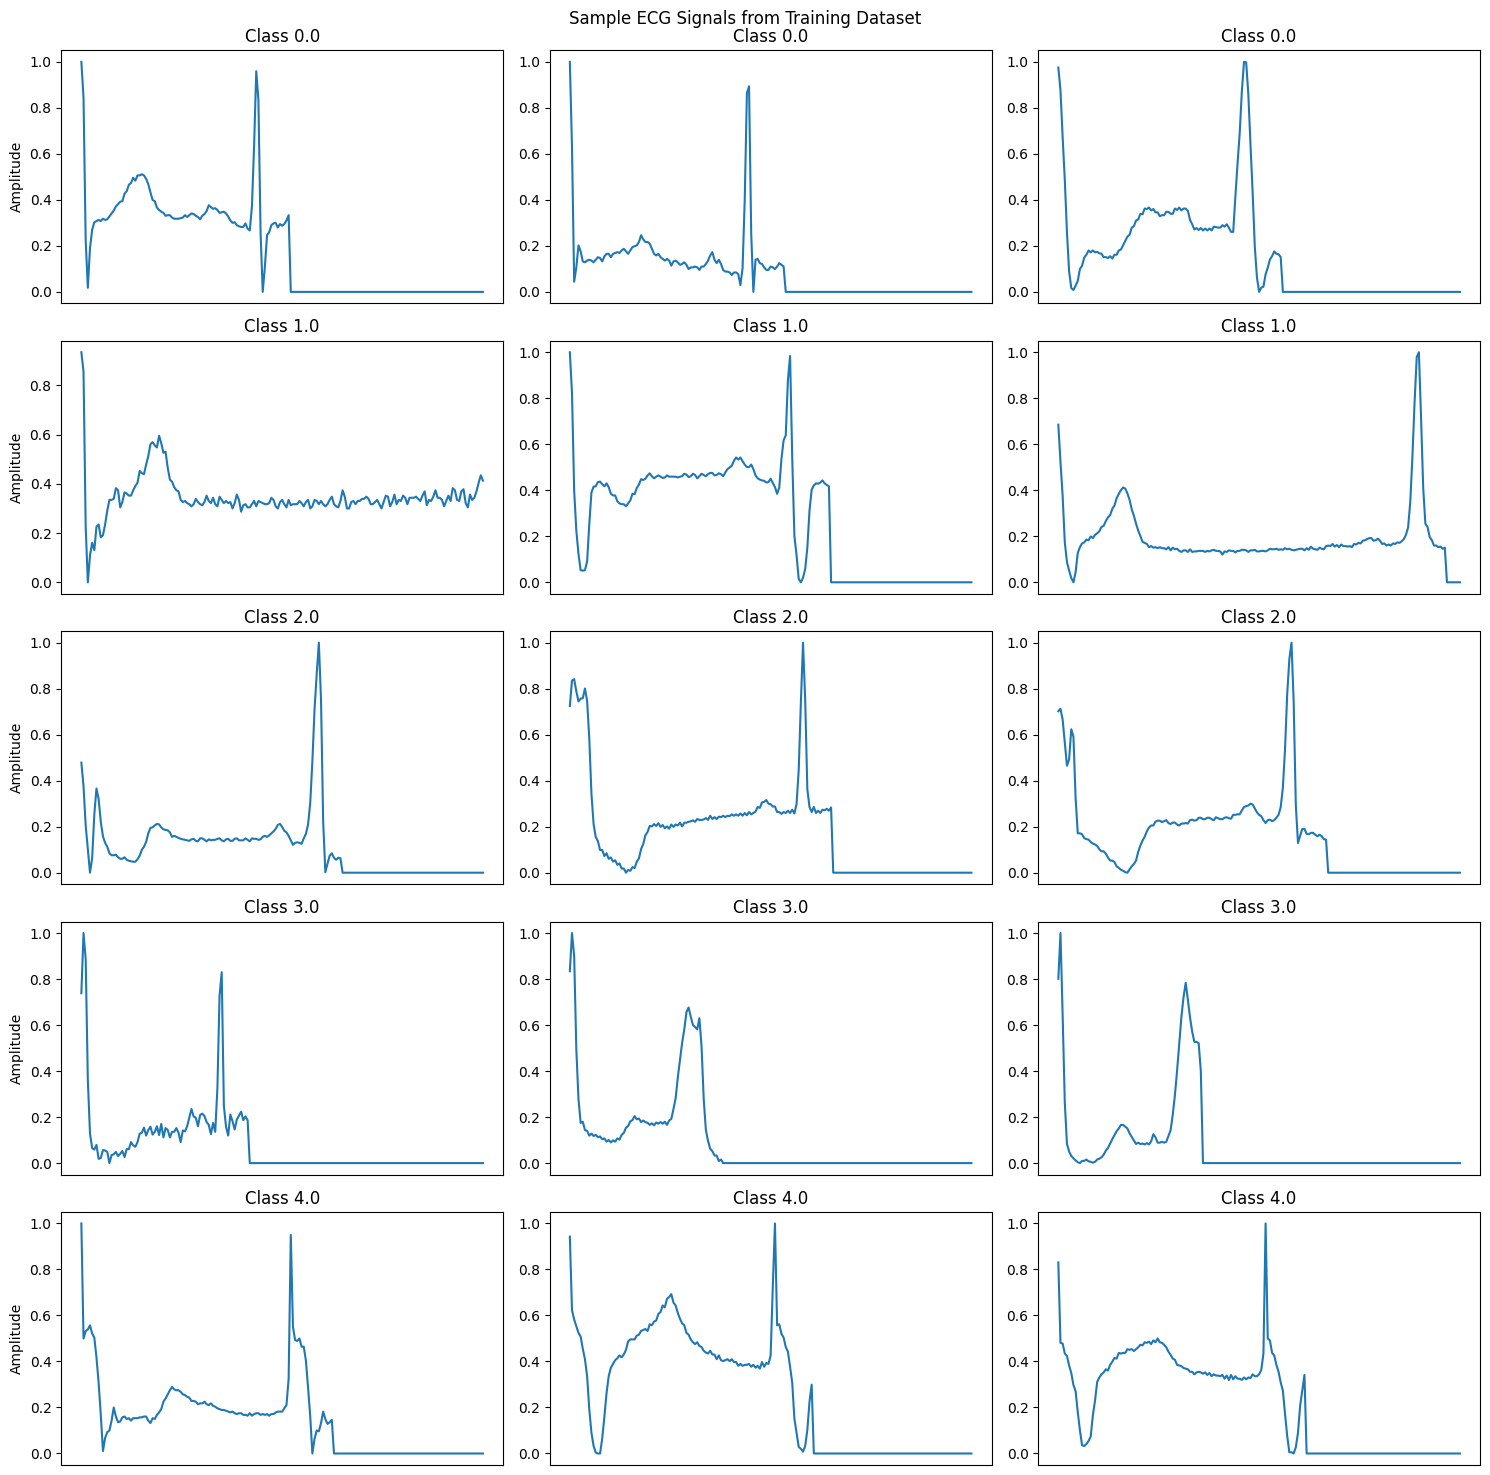


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [10]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# DATA AUGMENTATION PORTION

## data augmentation: additive noise + crop

In [11]:
import numpy as np

def additive_noise(dataset, noise_min= 0.000, noise_max= 0.0369, add_gaussian= True, add_jitter= True):
    noise_lvl = np.random.uniform(noise_min, noise_max)
    noisy_dataset = dataset.copy()

    if add_gaussian:
        gaussian_noise = np.random.normal(loc= 0.0, scale= noise_lvl, size= dataset.shape)
        noisy_dataset += gaussian_noise
    if add_jitter:
        jitter_noise = np.random.uniform(-noise_lvl/2, noise_lvl/2, size=dataset.shape)
        noisy_dataset += jitter_noise

    return dataset

In [ ]:
def crop_dataset(dataset, start_index= None):
    dataset_size = dataset.shape[0]

    if not start_index:
        start_index = 0
    
    crop_size = np.random.randint(0, dataset_size)
    start_index = np.random.randint(0, dataset_size - crop_size + 1)

    end_index = start_index + crop_size
    cropped_dataset = dataset[start_index:end_index]

    final_dataset = np.resize(cropped_dataset, dataset.shape)

    return final_dataset

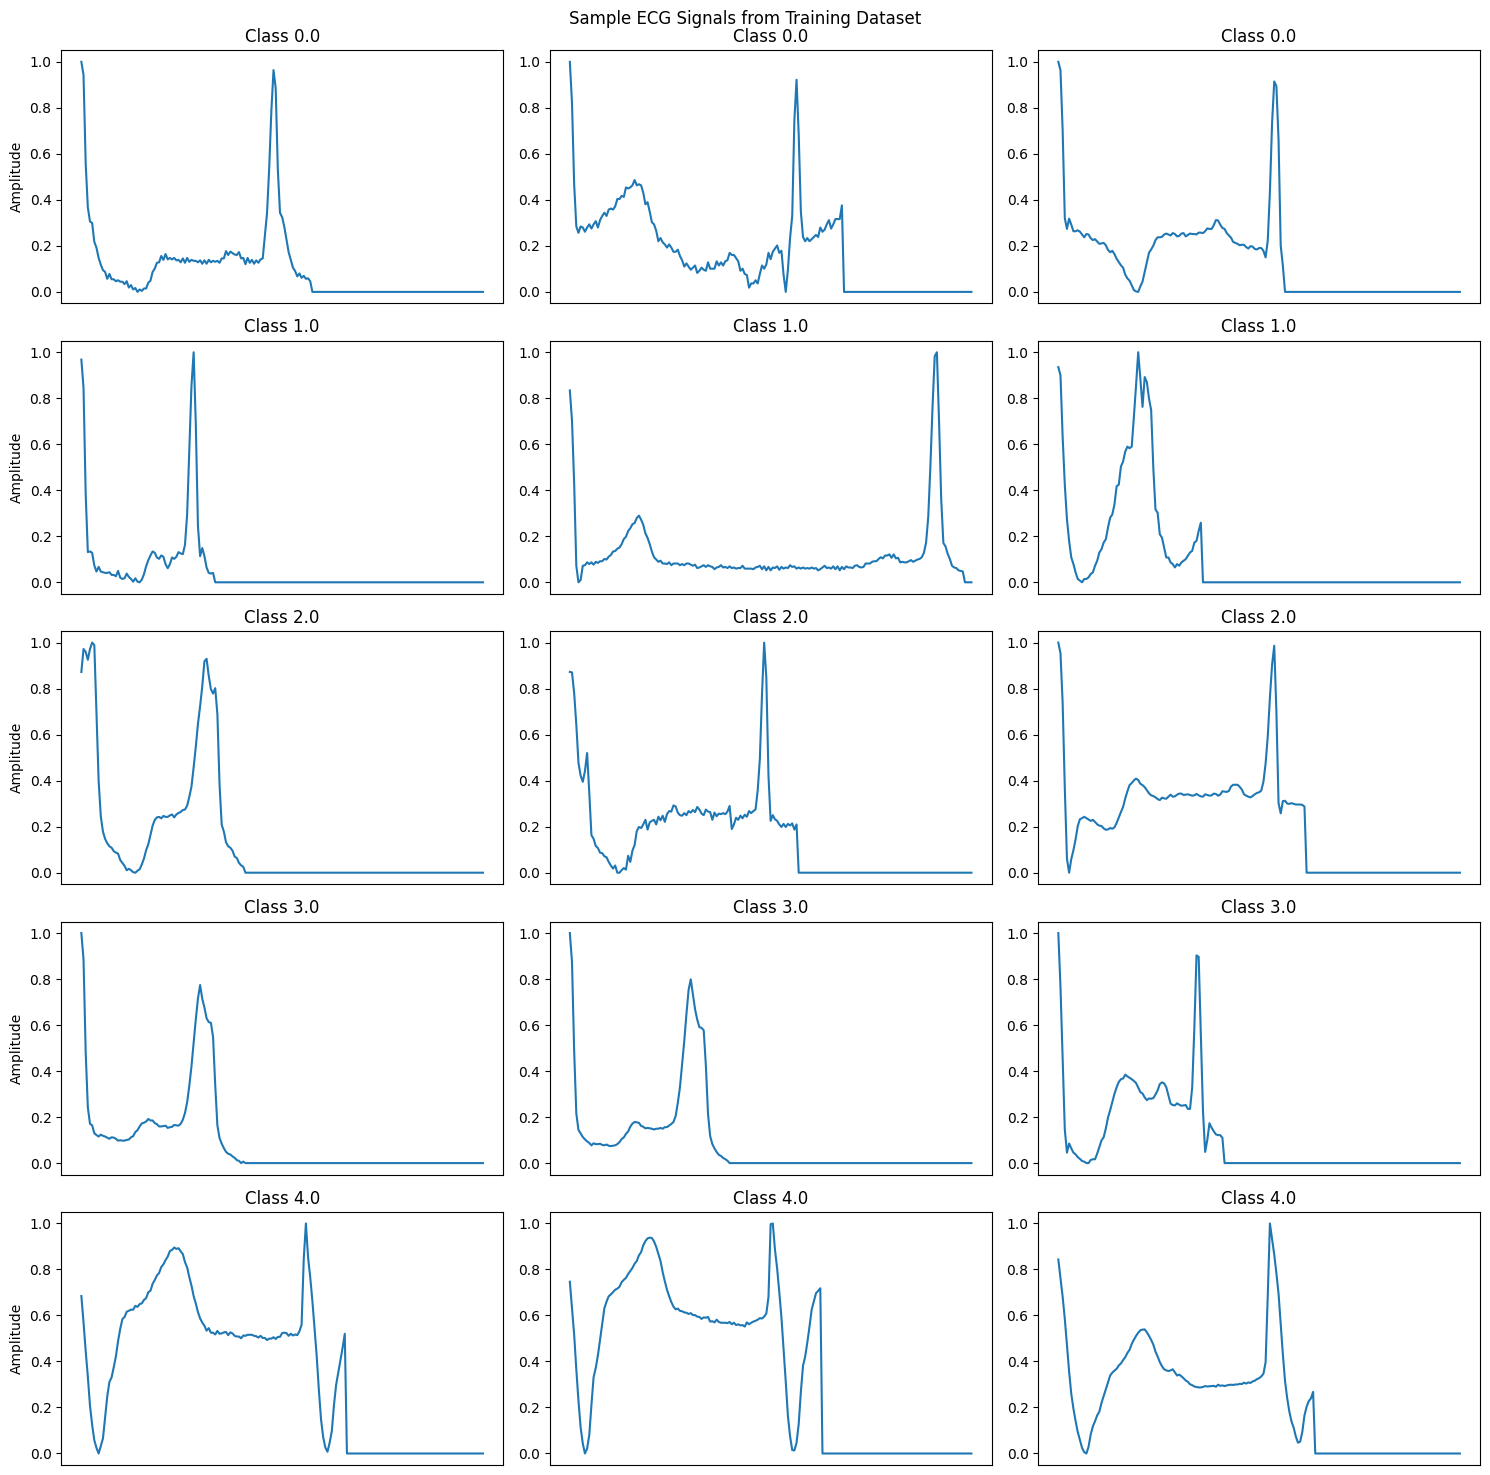

In [13]:
exp0 = additive_noise(X_train)

plot_sample_signals(exp0, y_train, "Training")

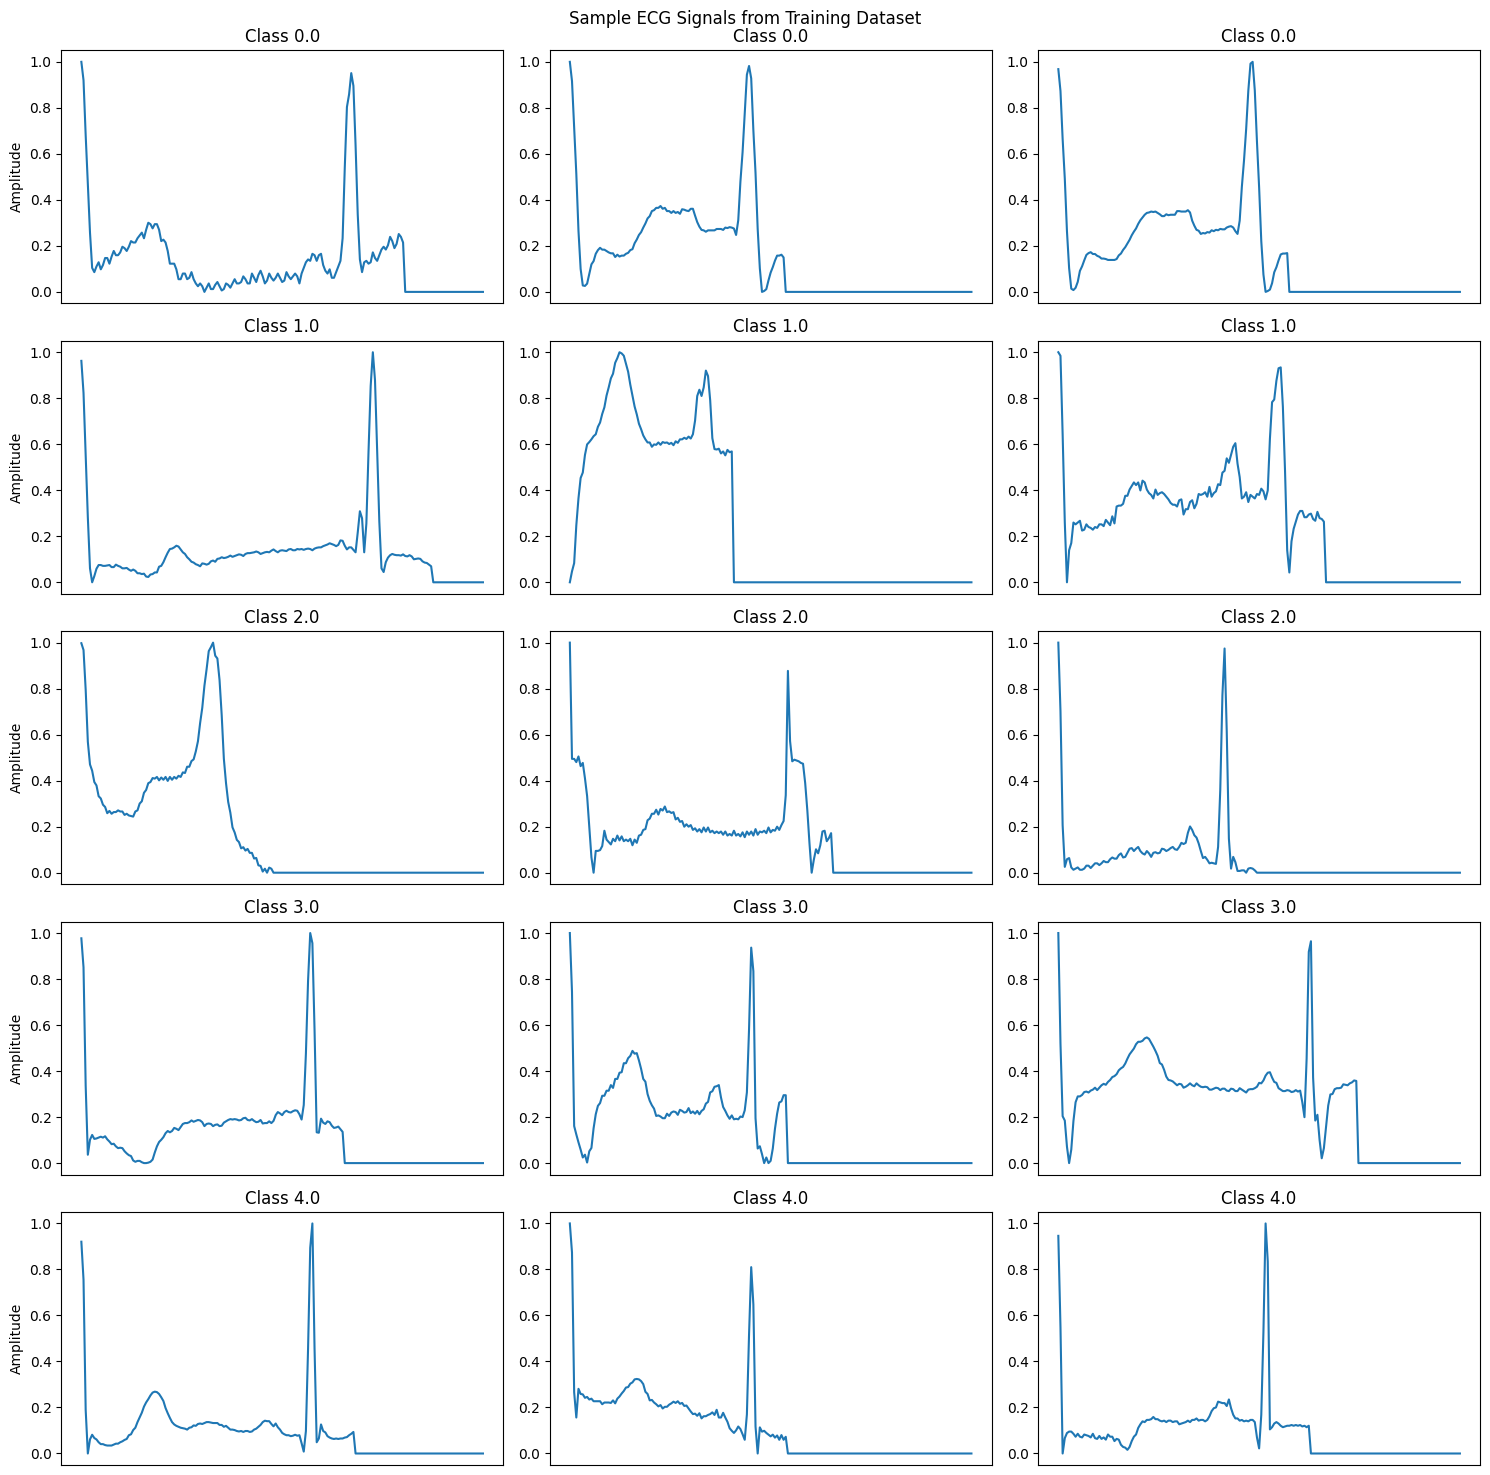

In [14]:
exp1 = crop_dataset(X_train)

plot_sample_signals(exp1, y_train, "Training")